## Predict avocado price using timeseries regression

As the dataset consists of 4 years of weekly retail scan data on avocado prices, a possible task is to train a Linear Regression model to predict the nest week's avocado price

Attributes:

* Date: the current year and month (for reference only, do NOT use for training/prediction)
* t-5:  AveragePrice at (Date - 5 weeks) 
* t-4:  AveragePrice at (Date - 4 weeks) 
* t-3:  AveragePrice at (Date - 3 weeks)
* t-2:  AveragePrice at (Date - 2 weeks) 
* t-1:  AveragePrice at (Date - 1 week) 

Target variable to predict:

* AveragePrice: average price at respective week of current_date

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import learning_curve
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle
import numpy as np

%matplotlib inline

### Data exploration before generating shifted feature
As original dataset has the average price for different regions and types for the same date, it becomes duplicated data when using timeseries regression

In [2]:
# read csv file and pass index_col=0 to tell that the first column is the index column
df_raw = pd.read_csv('./avocado.csv', index_col=0, parse_dates=['Date']) 

In [3]:
print('Number of unique Date is: ', len(set(df_raw['Date'])))
print('Total number of Dates (rows) is: ', len((df_raw['Date'])))

Number of unique Date is:  169
Total number of Dates (rows) is:  18249


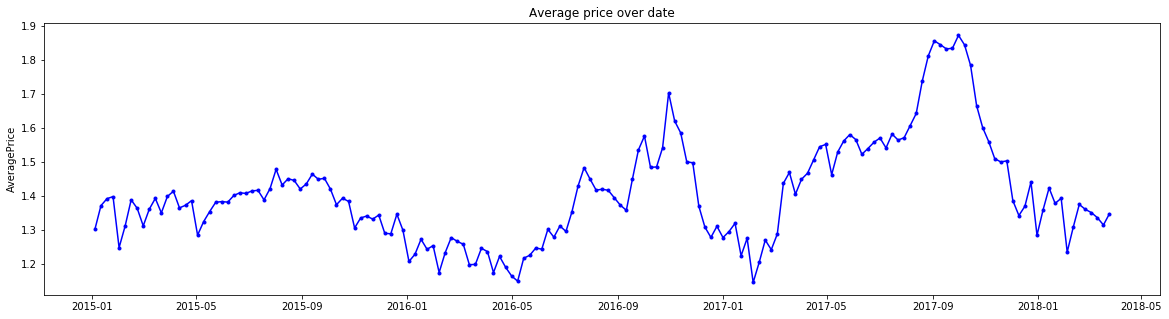

In [4]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.set_title('Average price over date')
ax.set_ylabel('AveragePrice')
ax.plot(df_raw.groupby(['Date'])['AveragePrice'].mean(), color="blue", marker=".")
plt.show()

In [5]:
df_raw['AveragePrice_Mean'] = df_raw['AveragePrice'].groupby(df_raw['Date']).transform('mean')

In [6]:
df_raw = df_raw[['Date', 'AveragePrice_Mean']].drop_duplicates()

In [7]:
len(df_raw)

169

In [8]:
# sort values by ascending order
df_raw.sort_values("Date", axis = 0, ascending = True, inplace = True, ignore_index=True) 

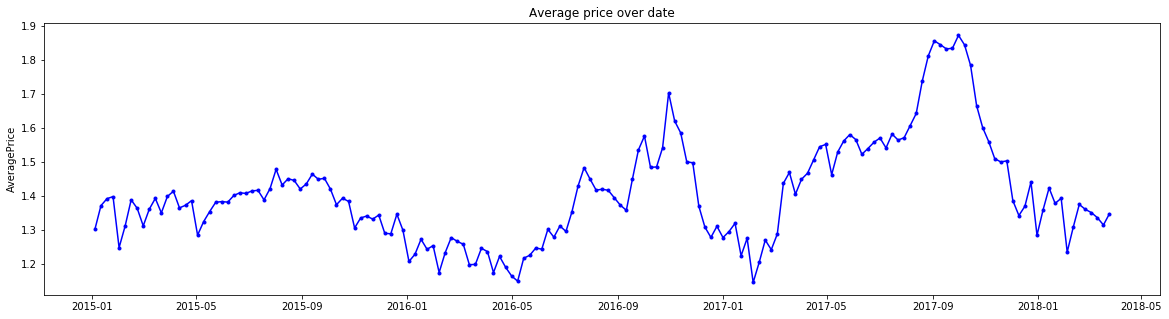

In [9]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.set_title('Average price over date')
ax.set_ylabel('AveragePrice')
ax.plot(df_raw['Date'], df_raw['AveragePrice_Mean'], color="blue", marker=".")
plt.show()

### Generate shifted features and save data to csv
Convert to supervised learning

In [10]:
# create 5 new features by shifting series in time
lag = 6

series = [df_raw['AveragePrice_Mean'].shift(-i) for i in range(lag)]
col_names = ['t-{}'.format(i) for i in range(lag)]

df_windowed = pd.concat(series, axis=1) #.dropna()
df_windowed.columns = col_names
df_windowed.head()

,t-0,t-1,t-2,t-3,t-4,t-5
0,1.301296,1.370648,1.391111,1.397130,1.247037,1.310463
1,1.370648,1.391111,1.397130,1.247037,1.310463,1.387593
2,1.391111,1.397130,1.247037,1.310463,1.387593,1.362685
3,1.397130,1.247037,1.310463,1.387593,1.362685,1.311019
4,1.247037,1.310463,1.387593,1.362685,1.311019,1.360093


In [11]:
df_csv = pd.concat([df_raw[['Date','AveragePrice_Mean']], df_windowed.loc[:,'t-1':]], axis=1).dropna()
# save to csv and use it as primary data source of this prediction task 
df_csv.to_csv('avocado_window.csv')

### Data exploration of avocado_window.csv

In [12]:
df = pd.read_csv('./avocado_window.csv', index_col=0, parse_dates=['Date']) 

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 164 entries, 0 to 163
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Date               164 non-null    datetime64[ns]
 1   AveragePrice_Mean  164 non-null    float64       
 2   t-1                164 non-null    float64       
 3   t-2                164 non-null    float64       
 4   t-3                164 non-null    float64       
 5   t-4                164 non-null    float64       
 6   t-5                164 non-null    float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 10.2 KB


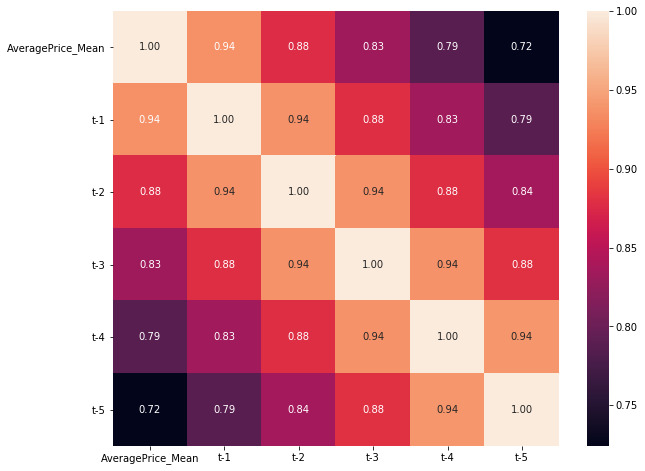

In [14]:
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(df.corr(), fmt='.2f', annot=True, ax=ax)

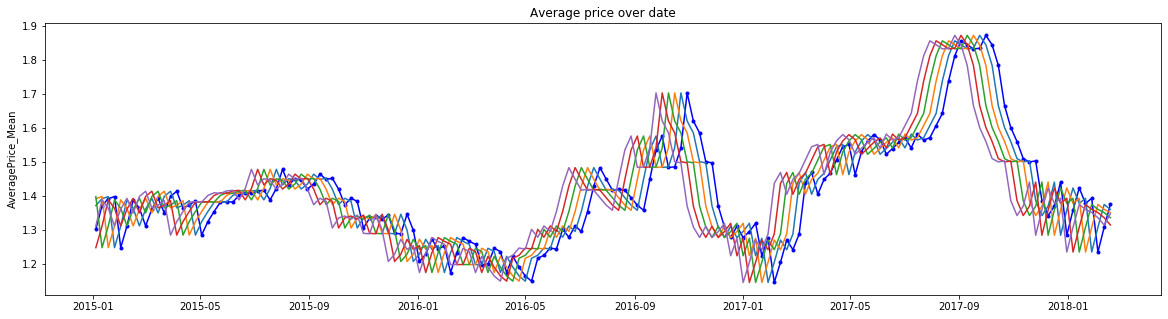

In [15]:
fig, ax = plt.subplots(figsize=(20, 5))

ax.set_title('Average price over date')
ax.set_ylabel('AveragePrice_Mean')
ax.plot(df['Date'], df['AveragePrice_Mean'], color="blue", marker=".")
ax.plot(df['Date'], df['t-1'])
ax.plot(df['Date'], df['t-2'])
ax.plot(df['Date'], df['t-3'])
ax.plot(df['Date'], df['t-4'])
ax.plot(df['Date'], df['t-5'])
# ax.plot(df['Date'], df['t-6'])
# ax.plot(df['Date'], df['t-7'])
# ax.plot(df['Date'], df['t-8'])
# ax.plot(df['Date'], df['t-9'])
# ax.plot(df['Date'], df['t-10'])
plt.show()

### Feature reduction & scaling 
Feature reduction is not needed because the number of features is small and we are trying to predict a trend from past values.

Feature scaling is not needed because the columns are all historical interest rates (same ranges).

### Autocorrelation plots
Autocorrelation plots are a way to visualise how far back a current value is correlated to values in the past.

This can be used to determine the limits of the window size.

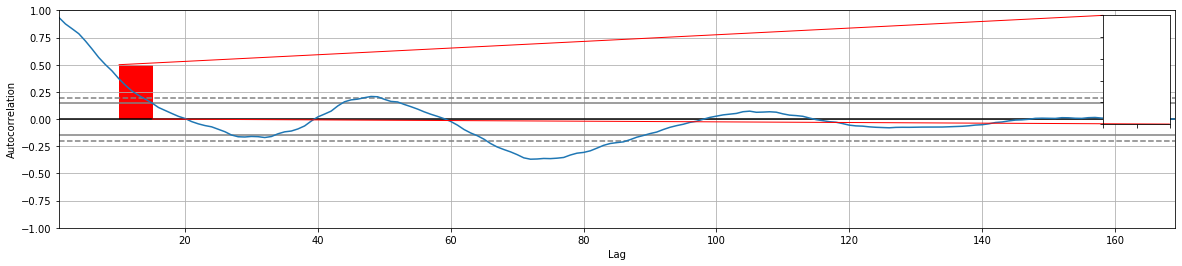

In [63]:
from pandas.plotting import autocorrelation_plot
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes

plt.figure(figsize=(20,4))
autoplt = autocorrelation_plot(df_raw['AveragePrice_Mean'])
axins = zoomed_inset_axes(autoplt,2, loc=1)
axins.set_xlim(10, 15)  
axins.set_ylim(0.0, 0.5)
plt.xticks(visible=False)
plt.yticks(visible=False)
mark_inset(autoplt, axins, loc1=2, loc2=4, fc="red", ec="red")
plt.draw()
plt.show();
# wanted to show the zoomed part but the zoomed area was empty

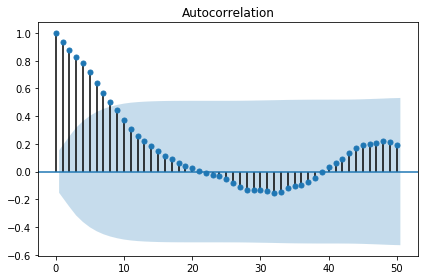

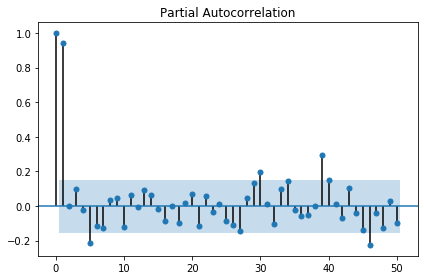

In [94]:
import statsmodels.tsa.api as smt

smt.graphics.plot_acf(df['AveragePrice_Mean'], lags=50)
plt.tight_layout()
smt.graphics.plot_pacf(df['AveragePrice_Mean'], lags=50)
plt.tight_layout()

#### Observations:
* the window size is from 1 to 12

### Train model
Omit the Date column when predicting the price

In [95]:
print('max date is: ', df['Date'].max(), 'min date is: ', df['Date'].min(), sep='\n')

max date is: 
2018-02-18 00:00:00
min date is: 
2015-01-04 00:00:00


In [96]:
features = (df.columns != 'AveragePrice_Mean') & (df.columns != 'Date')

target = 'AveragePrice_Mean'
train_range = df['Date'] < '2018-01-01' 
test_range = df['Date'] >= '2018-01-01' 

X_train = df.loc[train_range, features]
y_train = df.loc[train_range, target]
X_test = df.loc[test_range, features]
y_test = df.loc[test_range, target]

In [97]:
model = SGDRegressor(random_state=42, verbose=True)
model.fit(X_train, y_train)
model.score(X_test, y_test)

-- Epoch 1
Norm: 0.41, NNZs: 5, Bias: 0.128169, T: 157, Avg. loss: 0.046808
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 0.40, NNZs: 5, Bias: 0.126733, T: 314, Avg. loss: 0.002865
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 0.41, NNZs: 5, Bias: 0.126925, T: 471, Avg. loss: 0.002863
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 0.40, NNZs: 5, Bias: 0.126097, T: 628, Avg. loss: 0.002815
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 0.40, NNZs: 5, Bias: 0.126525, T: 785, Avg. loss: 0.002844
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 0.41, NNZs: 5, Bias: 0.127218, T: 942, Avg. loss: 0.002835
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 0.41, NNZs: 5, Bias: 0.127736, T: 1099, Avg. loss: 0.002817
Total training time: 0.00 seconds.
Convergence after 7 epochs took 0.00 seconds


-0.1564088987342056

### Evaluation metrics
Use mean_squared_error, mean_absolute_error

In [98]:
y_pred = model.predict(X_test)
print(mean_squared_error(y_test, y_pred))
print(mean_absolute_error(y_test, y_pred))

0.003912191017085828
0.05070324647153522


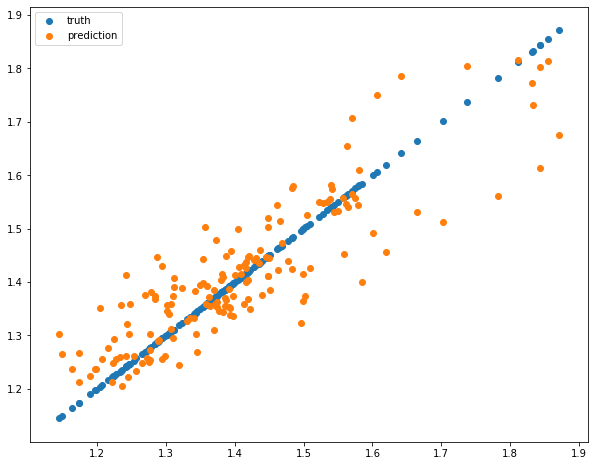

In [99]:
# show the whole series

X = df.loc[:, features]
y = df.loc[:, target]
y_pred = model.predict(X)

fig, ax = plt.subplots(figsize=(10, 8))

ax.scatter(df['AveragePrice_Mean'], y, label='truth')
ax.scatter(df['AveragePrice_Mean'], y_pred, label='prediction')
ax.legend()

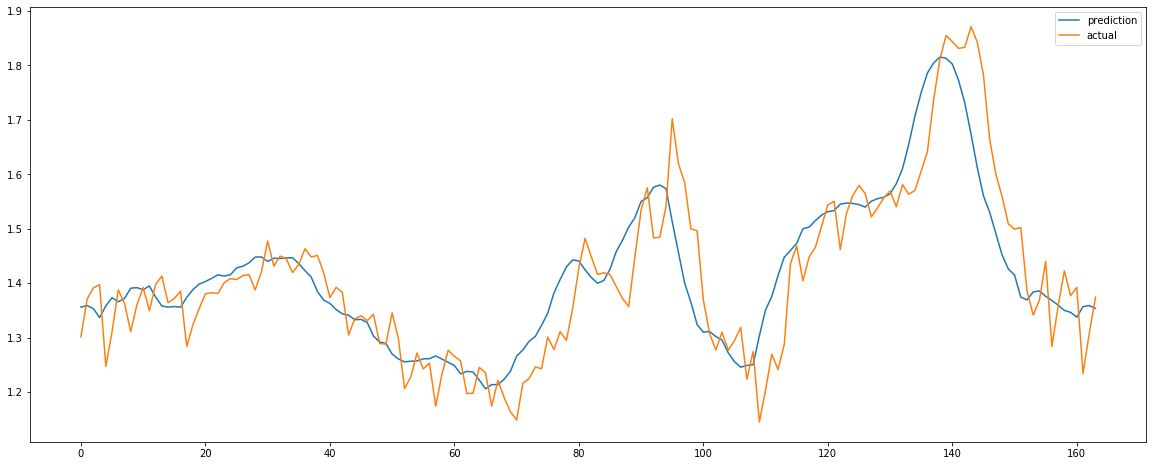

In [113]:
plt.figure(figsize=(20,8))
plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
plt.plot(y_pred, label ='prediction')
plt.plot(df['AveragePrice_Mean'], label ='actual')
plt.legend()